---
# 머신러닝을 통한 댐에 유입되는 수량 예측

팀명: 최적00<br>
팀원: 최대원, 임정섭

개발환경: Colab

---

구글 드라이브에 마운트 한다

In [ ]:
from google.colab import drive
drive.mount('/content/mydrive')

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


경로설정

In [ ]:
import os

os.chdir('/content/mydrive/Shareddrives/빅콘테스트_홍수ZERO')

Numpy, Pandas를 import한다.

In [ ]:
import numpy as np
import pandas as pd

크롤링한 외부데이터를 여는데 필요한 pickle5를 설치하고 import 한다

In [ ]:
!pip3 install pickle5
import pickle5 as pickle

     |████████████████████████████████| 132 kB 27.2 MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219300 sha256=e7ca44722f0236440f4e51a0c32af3540dcfbdde7f47956c1453d1359ab4553a
  Stored in directory: /root/.cache/pip/wheels/7e/6a/00/67136a90d6aca437d806d1d3cedf98106e840c97a3e5188198
Successfully built pickle5


# 특징 공학

특징공학(feature engineering)은 머신러닝 모델에 입력할 적절한 특징을 추출, 선택, 변환하는 작업이다. 이러한 과정은 데이터에 대한 이해를 바탕으로 이루어지며, 모델의 성능을 좌우한다.
진행한 작업은 다음과 같다.

1. 크롤링을 통해 추출한 **외부 데이터**를 가져와 새로운 columns을 형성.
2. 종속변수 inflow와의 상관관계를 계산하고 상위 11개의 열에 대해 **이상치를 제거**
3. year, hour 등 첨도가 치우칠 수 밖에 없는 columns는 제외하고 나머지 columns에 **첨도**를 계산하고, 1 이상의 값을 가지는 칼럼들은 **log 스케일링**을 적용-> 데이터의 첨도 완화
4. **year, day, hour**를 나누어 columns 추가, 홍수사상별 시간에 따른 진행율을 나타내는 **period_rate** 칼럼 추가
5.홍수사상을 구분하는 **더미변수** 추가
5. 홍수사상 1~25번과 26번 분리.
6. 1~25을 먼저 **normalize**하고, tramsform을 통해 26번도 **normalize**.
7. **select from model**을 통해, 머신러닝 모델을 사용해, 모델 성능을 극대화하는 칼럼들을 선택.

크롤링을 통해 추출한 외부데이터를 가져오는 함수

In [ ]:
def create_other_dams(filename):
    # pickle 파일을 읽기
    with open(filename, 'rb') as handle:
        dam_dict = pickle.load(handle)

    other_dams_df = pd.concat(dam_dict.values(), keys=dam_dict.keys(), axis=1)

    return other_dams_df

이상치 제거를 위해, inflow 칼럼과 상관간계를 계산해 지정한 갯수 만큼의 상위 칼럼들을 반환하는 함수

In [ ]:
def get_corr_cols(X_df, y_df, corr_num):
    
    corr = X_df.corrwith(y_df).sort_values(ascending=False)
    corr.index = corr.index.to_flat_index()
    corr_cols = corr.index[:corr_num+1].values.tolist()
    
    return corr_cols

## prepocess 함수(칼럼추가, 이상치제거, 스케일링)

preprocess.py 파일로 부터 전처리에 필요한 모든 함수들을 import 한다. 
(함수각각에 대한 자세한 설명은 preprocess.py 파일 참조)


칼럼 선택을 제외한 **모든 데이터 전처리를 한번에** 수행한 후, 홍수사상 1~25번 데이터(X_flood_df, y_flood_df)와 26번 데이터(X_eval_df, y_eval_df)를 각각 반환하는 함수.

In [ ]:
from preprocess import *

def preprocess(filename):
    X_df, y_df = create_dataframe(filename, eval=True, flood_id=False, period_col=True)

    other_dams = create_other_dams('./crawling/other_dams.pkl')
    # other_dams.loc[:, pd.IndexSlice[:, 'storage_rate']] /= 100
    X_df = X_df.join(other_dams)

    corr_cols = get_corr_cols(X_df.loc[:25], y_df.loc[:25], 11)
    X_temp, y_temp = drop_outlier(X_df.loc[:25], y_df.loc[:25], corr_cols, method='zscore')
    X_df = pd.concat([X_temp, X_df.loc[26:27]])
    y_df = pd.concat([y_temp, y_df.loc[26:27]])
    
    skew_cols = X_df.drop(columns=['year', 'month', 'day', 'hour'], level=0).loc[:, X_df.skew().abs() > 1].columns
    X_df = take_log(X_df, skew_cols)
    
    X_df = mutate_period_rate(X_df)
    X_df = mutate_flood_id(X_df)
    X_df = mutate_dummies(X_df, 'flood_id')
    del X_df['flood_id']
    
    X_flood_df, X_eval_df = X_df.loc[:25], X_df.loc[26:27]
    y_flood_df, y_eval_df = y_df.loc[:25], y_df.loc[26:27]
    
    X_eval_df = scale(X_flood_df, X_eval_df, df=True, method='n')
    X_flood_df = scale(X_flood_df, df=True, method='n')
    
    return X_flood_df, X_eval_df, y_flood_df, y_eval_df

preprocess 함수를 실행하여 데이터를 반환 받는다.

In [ ]:
X_flood_df, X_eval_df, y_flood_df, y_eval_df = preprocess('flood_data.xlsx')

반환받은 데이터를 확인한다.(상위 5개의 행)

아래에서 확인할 수 있듯, y_eval_df에는 예측해야 할 유입량이 결측값으로 나타나 있음.

In [ ]:
print(X_flood_df.head())
print()
print(y_flood_df.head())
print()
print(X_eval_df.head())
print()
print(y_eval_df.head())

dataset                                   1             ... flood_id_25 flood_id_26
variable                  rainfall_mean_all rainfall_A  ...                        
flood_id period                                         ...                        
1        2006-07-10 08:00          0.031083   0.365868  ...         0.0         0.0
         2006-07-10 09:00          0.030597   0.365868  ...         0.0         0.0
         2006-07-10 10:00          0.031083   0.365868  ...         0.0         0.0
         2006-07-10 11:00          0.035454   0.365868  ...         0.0         0.0
         2006-07-10 12:00          0.039825   0.365868  ...         0.0         0.0

[5 rows x 241 columns]

flood_id  period          
1         2006-07-10 08:00    189.100000
          2006-07-10 09:00    216.951962
          2006-07-10 10:00    251.424419
          2006-07-10 11:00    302.812199
          2006-07-10 12:00    384.783406
Name: inflow, dtype: float64

dataset                                  

반환받은 데이터의 shape를 확인한다.

총 칼럼의 수는 241개인 것을 확인할 수 있다.

In [ ]:
print(X_flood_df.shape)
print(y_flood_df.shape)
print(X_eval_df.shape)
print(y_eval_df.shape)

(2636, 241)
(2636,)
(160, 241)
(160,)


## 모델평가에 사용할 기본 함수

모델을 훈련하고 평가할때, 사용할 기본 함수로써, 이후 모델 기반 칼럼 선택에도 활용됨.

1. **train_eval_rmse(model, X_train, y_train, X_test, y_test)**
: 모델과 훈련데이터, 평가데이터를 입력으로 넣어주면, 모델을 훈련 후, 평가데이터를 바탕으로 한, rmse 반환하는 함수. 

2. **eval_model_cv(model, X_train, y_train)**
: 교차검증을 위한 함수, fold는 5, seed는 42로 임의 설정함. 훈련데이터를 넣어주면, fold에 따라 5개의 데이터셋으로 나눈 후, 4개를 훈련데이터 나머지 하나를 검증데이터로 사용함. 이 과정을 5번 순차별로 반복 후, 검증데이터를 바탕으로 계산된 5개의 rmse의 평균값을 반환하는 함수.



In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold # for repeated K-fold cross validation
from sklearn.model_selection import cross_val_score # score evaluation


def train_eval_rmse(model, X_train, y_train, X_test, y_test):
        model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        mse = mean_squared_error(y_test, prediction)
        rmse = np.sqrt(mse)
        print('this model RMSE is {:.4f}'.format(rmse))
        return rmse


SEED = 42
kfolds = KFold(n_splits=5, shuffle=True, random_state=SEED)


def evaluate_model_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kfolds))
    rmse = rmse.mean()
    print('this model RMSE is {:.4f}'.format(rmse))
    return rmse

## 모델 기반 칼럼 선택

데이터에서 칼럼(feature)를 선택하는 방법에는 분산을 활용한 선택, 단변량 특성 선택, 모델 기반 선택 등 많은 방법들이 존재한다. 여기서 우리는 **모델 기반 선택(select from model)방법**을 택했다. 모델 기반 선택은 모델을 먼저 훈련 데이터로 훈련시키고, ‘feature_importance_’ 메서드를 통해 각 칼럼의 중요도를 계산한다. 이후 사용자가 특정 임계값을 정해주면, 이 임계값 이상의 중요도를 가지는 칼럼들을 선택하는 방식이다. 우리는 XGBRegressor을 사용했고, 임계값을 **‘교차검증의 RMSE’가 최소’**가 되도록 하는 값으로 정했다. 

**홍수사상 1~25번에 대한 데이터(X_flood_df, y_flood_df)**를 **Train, Test 데이터로 분리**한다. 비율은 4:1로 하고, random_state는 70으로 임의설정한다.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_flood_df, y_flood_df, random_state=70, test_size=0.2)

**select_columns(model, X_train, y_train**): XGBRegressor를 훈련을 시키고, 칼럼 중요도를 계산한다. 그리고 이를 오름차순으로 정리한 배열을 threshold에 저장한다. 그리고 반복문을 통해 threshold에 담긴 값을  늘려가면서 교차검증을 수행하고 RMSE가 최소가 되는 임계값을 찾는다.

찾은 임계값을 바탕으로 최종적으로 **교차검증의 RMSE가 최소가 되는 칼럼을 선택**해 반환한다.

In [ ]:
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor


def select_columns(model, X_train, y_train):
    model.fit(X_train, y_train)
    columns_importance = model.feature_importances_
    threshold = np.sort(columns_importance) # 중요도 오름차순
    rmse_list = []
    
    for thresh in threshold[:]: 
        # select features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        selection_model = XGBRegressor(verbosity=0)
        rmse = np.sqrt(-cross_val_score(selection_model, select_X_train, y_train, scoring="neg_mean_squared_error", cv=kfolds))
        rmse = rmse.mean()
        print(f'when threshold is {thresh:.4f}, model RMSE is {rmse:.4f}',  end='\n')
        rmse_list.append(rmse)

    best_threshold = threshold[np.argmin(rmse_list)]
    print(f'best threshold is {best_threshold}')
    
    columns_selected = X_train.columns[columns_importance>= best_threshold]

    return columns_selected

select_columns 함수를 실행하고, 교차검증의 RMSE가 최소가 되는 임계값을 확인한다.

-> threshold가 **0.0010607525473460555**일떄, RMSE가 최소인 것을 확인할 수 있다.

또한 이때, 선택된 칼럼들을 **columns_selected**c에 반환 받는다.

In [ ]:
columns_selected = select_columns(XGBRegressor(), X_train, y_train)

[02:36:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
when threshold is 0.0000, model RMSE is 216.1874
when threshold is 0.0000, model RMSE is 216.1874
when threshold is 0.0000, model RMSE is 216.1874
when threshold is 0.0000, model RMSE is 216.1874
when threshold is 0.0000, model RMSE is 216.1874
when threshold is 0.0000, model RMSE is 216.1874
when threshold is 0.0000, model RMSE is 216.1874
when threshold is 0.0000, model RMSE is 216.1874
when threshold is 0.0000, model RMSE is 216.1874
when threshold is 0.0000, model RMSE is 216.1874
when threshold is 0.0000, model RMSE is 216.1874
when threshold is 0.0000, model RMSE is 216.1874
when threshold is 0.0000, model RMSE is 216.1874
when threshold is 0.0000, model RMSE is 216.1874
when threshold is 0.0000, model RMSE is 216.1874
when threshold is 0.0000, model RMSE is 216.1874
when threshold is 0.0000, model RMSE is 216.1874
when threshold is 0.0000, model RMSE is 

선택된 칼럼을 확인한다.


In [ ]:
print(columns_selected, end='\n\n')

MultiIndex([(            1,        'rainfall_A'),
            (            1,        'rainfall_C'),
            (            1,        'rainfall_D'),
            (            1,      'waterlevel_E'),
            (            2,      'waterlevel_D'),
            (            3,        'rainfall_B'),
            (            3,        'rainfall_D'),
            (            4, 'rainfall_mean_all'),
            (            4,        'rainfall_A'),
            (            4,        'rainfall_C'),
            (            4,        'rainfall_D'),
            (            4,      'waterlevel_D'),
            (            5, 'rainfall_mean_all'),
            (            6, 'rainfall_mean_all'),
            (            6,        'rainfall_C'),
            (            6,        'rainfall_D'),
            (        'day',                  ''),
            (       '소양강댐',            'inflow'),
            (       '소양강댐',         'discharge'),
            (        '횡성댐',        'waterlevel'),


처음 241개의 칼럼 중 78개가 선택되었다.

In [ ]:
print(f'원래 칼럼의 수는 {X_train.shape[1]}개')
print(f'선택된 칼럼의 수는 {columns_selected.shape[0]}개')

원래 칼럼의 수는 241개
선택된 칼럼의 수는 78개


선택된 칼럼을 Train, Test 데이터에 적용한다. (y_train, y_test는 칼럼이 종속변수 하나이므로, 적용할 필요 없음)





In [ ]:
X_train = X_train[columns_selected]
X_test = X_test[columns_selected]

# 모델구축

단일모델을 사용하는 것이 아닌, 여러 모델들을 결합하는 **스태킹(Stacking)**을 사용했다. 스태킹 모델을 세부적으로 살펴보면, **regressor, meta_regressor** 로 이루어져 있다. 쉽게 말하면, 여러 regressor가 훈련을 통해 예측한 데이터를 취합해, 최종적으로 meta_regressor가 예측하는 원리이다. 이러한 원리 때문에, 스태킹에 사용되는 모델들 각각의 성능이 최종성능에 중요하게 작용한다.


스태킹의 사용할 모델은 **총 5개**로 정했고, 수많은 머신러닝 가운데, 뛰어난 성능을 낸다고 알려진 앙상블, 부스팅 계열의 모델들이다. 
1. XGBRegressor
2. ExraTreeRegressor
3. LGBM
4. RandomForestRegressor
5. GradientBoostingRegressor


# 모델평가

앞서 홍수 사상 1~25를 Train, Test로 분리했고, 각각의 데이터셋의 역할은 다음과 같다.

1.Train 데이터: 모델의 **훈련과 교차검증** 등에 활용됨.

2.Test 데이터: **모델의 훈련과정에는 일체 관여하지 않았고**, **최종적인 성능 확인**을 위해 쓰임.




프로젝트에 사용할 모든 모델들의 성능의 평가지표는 **RMSE**이고, 다음 **3단계의 프로세스**를 거쳐서 평가했다. 

**1단계)** Train 데이터에 대한 RMSE 평가 

**2단계)** 5 fold 교차검증을 통한 RMSE 평가 

**3단계)** Test 데이터에 대한 RMSE 평가


**1단계와 2단계의 결과를 비교**함으로써, 모델의 과적합(overfit, underfit)을 파악했고, 이를 모델성능의 판단척도로 삼았다. 충분한 모델 최적화 후에 만들어진 최종모델은 **마지막으로 3단계 결과를 활용**해 실전에서 나타날 최종적인 성능을 판단했다. 

# 단일모델 최적화(by Grid Search)

먼저, 스태킹에 활용할 **5개의 단일 모델 각각을 최적화**했다. 구체적인 방법은 GridSearchCV를 활용했고, 모델마다 핵심 파라미터들의 값의 범위를 조정하면서, 파라미터 조합을 찾아나갔다. 

그리드서치를 위해 필요한 sklearn의 GridSearchCV를 import 한다. 또한 Train, Test 데이터를 넘파이 배열로 변환한다.

In [ ]:
from sklearn.model_selection import GridSearchCV

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


## XGBRegressor

디폴트 상태의 XGBRegressor의 성능을 확인한다.
-> 과소적합(underfitting)

In [ ]:
xgboost = XGBRegressor(verbosity=0)

print('훈련데이터 성능', end=' >> ')
train_eval_rmse(xgboost, X_train, y_train , X_train, y_train)
print('교차검증', end=' >> ')
evaluate_model_cv(xgboost, X_train, y_train)
print()

훈련데이터 성능 >> this model RMSE is 137.6546
교차검증 >> this model RMSE is 213.5850



그리드서치를 이용한 XGBRegressor의 최적의 하이퍼파라미터 조합 찾은 후, 성능을 확인한다.

-> 과대적합이긴 하지만, 훈련데이터와 교차검증 모두 RMSE가 줄어들었다.

In [ ]:
param_grid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [.07], #so called `eta` value
              'max_depth': [5],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [1000]}

grid_search = GridSearchCV(XGBRegressor(), param_grid, cv=5, return_train_score=True, scoring ='neg_root_mean_squared_error')


grid_search.fit(X_train, y_train)
print('최적의 파라미터',grid_search.best_params_)
print()
best_xg = grid_search.best_estimator_

print('훈련데이터 성능', end=' >> ')
train_eval_rmse(best_xg, X_train, y_train , X_train, y_train)
print('교차검증', end=' >> ')
evaluate_model_cv(best_xg, X_train, y_train)
print()

최적의 파라미터 {'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 1000, 'nthread': 4, 'silent': 1, 'subsample': 0.7}

훈련데이터 성능 >> this model RMSE is 5.4604
교차검증 >> this model RMSE is 149.3781



Test 데이터를 활용해, 최종성능을 확인한다.

In [ ]:
print('최종확인', end=' >> ')
train_eval_rmse(best_xg, X_train, y_train, X_test, y_test)
print()

최종확인 >> this model RMSE is 175.7487



## ExtraTreeRegressor

디폴트 상태의 ExtraTreeRegressor의 성능을 확인한다.-> 과대적합(overfitting)

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
extra_tree = ExtraTreesRegressor()


print('훈련데이터 성능', end=' >> ')
train_eval_rmse(extra_tree, X_train, y_train , X_train, y_train)
print('교차검증', end=' >> ')
evaluate_model_cv(extra_tree, X_train, y_train)
print()

훈련데이터 성능 >> this model RMSE is 0.0000
교차검증 >> this model RMSE is 163.4359



그리드서치를 이용한 ExtraTreeRegressor의 최적의 하이퍼파라미터 조합 찾은 후, 성능을 확인한다.

-> 과대적합이 완화됨, 훈련데이터의 RMSE는 늘었지만, 교차검증의 RMSE는 줄어들었다.

In [ ]:
param_grid = {
    'n_estimators': [100,1000],
    'max_depth': [25,5],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],    
    'bootstrap':[False],
    'warm_start':[False],
    'min_impurity_decrease': [0.1]}

grid_search = GridSearchCV(ExtraTreesRegressor(), param_grid, cv=5, return_train_score=True, scoring ='neg_root_mean_squared_error')


grid_search.fit(X_train, y_train)
print('최적의 파라미터',grid_search.best_params_)
print()
best_extra = grid_search.best_estimator_

print('훈련데이터 성능', end=' >> ')
train_eval_rmse(best_extra, X_train, y_train , X_train, y_train)
print('교차검증', end=' >> ')
evaluate_model_cv(best_extra, X_train, y_train)
print()


최적의 파라미터 {'bootstrap': False, 'max_depth': 25, 'max_features': 'sqrt', 'min_impurity_decrease': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000, 'warm_start': False}

훈련데이터 성능 >> this model RMSE is 2.0930
교차검증 >> this model RMSE is 142.6306



Test 데이터를 활용해, 최종성능을 확인한다.

In [ ]:
print('최종확인', end=' >> ')
train_eval_rmse(best_extra, X_train, y_train, X_test, y_test)
print()

최종확인 >> this model RMSE is 206.9021



## LGBM

LGBM을 사용하기 위해 필요한 라이브러리를 설치한다.

In [ ]:
!pip install lightgbm

디폴트 상태의 LGBM의 성능을 확인한다.-> 과대적합(overfitting)

In [ ]:
import lightgbm as lgb

lgbm = lgb.LGBMRegressor()

print('훈련데이터 성능', end=' >> ')
train_eval_rmse(lgbm, X_train, y_train , X_train, y_train)
print('교차검증', end=' >> ')
evaluate_model_cv(lgbm, X_train, y_train)
print()

훈련데이터 성능 >> this model RMSE is 49.8621
교차검증 >> this model RMSE is 196.0074



그리드서치를 이용한 LGBM의 최적의 하이퍼파라미터 조합 찾은 후, 성능을 확인한다.

-> 과대적합이긴 하지만, 훈련데이터와 교차검증 모두 RMSE가 줄어들었다.

In [ ]:
param_grid = {'boosting_type':['gbdt'],
              'n_estimators':[2000],
              'objective':['regression'],
              'num_leaves':[31,40],
              'learning_rate':[0.1,0.07],
              'min_child_samples':[30],
              'max_depth':[3]

  }

grid_search = GridSearchCV(lgb.LGBMRegressor(), param_grid, cv=5, return_train_score=True, scoring ='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
print('최적의 파라미터',grid_search.best_params_)
print()
best_lgbm = grid_search.best_estimator_

print('훈련데이터 성능', end=' >> ')
train_eval_rmse(best_lgbm, X_train, y_train , X_train, y_train)
print('교차검증', end=' >> ')
evaluate_model_cv(best_lgbm, X_train, y_train)
print()

최적의 파라미터 {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'max_depth': 3, 'min_child_samples': 30, 'n_estimators': 2000, 'num_leaves': 31, 'objective': 'regression'}

훈련데이터 성능 >> this model RMSE is 20.4402
교차검증 >> this model RMSE is 158.1905



Test 데이터를 활용해, 최종성능을 확인한다.

In [ ]:
print('최종확인', end=' >> ')
train_eval_rmse(best_lgbm, X_train, y_train, X_test, y_test)
print()

최종확인 >> this model RMSE is 178.4348



## RandomForestRegressor

디폴트 상태의 RandomForestRegressor의 성능을 확인한다.-> 과소적합(underfitting)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

print('훈련데이터 성능', end=' >> ')
train_eval_rmse(rf, X_train, y_train , X_train, y_train)
print('교차검증', end=' >> ')
evaluate_model_cv(rf, X_train, y_train)
print()

훈련데이터 성능 >> this model RMSE is 82.9291
교차검증 >> this model RMSE is 231.9815



그리드서치를 이용한 RandomForestRegressor의 최적의 하이퍼파라미터 조합 찾은 후, 성능을 확인한다.

-> 과대적합이긴 하지만, 훈련데이터와 교차검증 모두 RMSE가 줄어들었다.

In [ ]:
param_grid = {
    'n_estimators': [50],
    'max_depth': [100],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'max_features': ['log2'],    
    'bootstrap':[False],
    'warm_start':[False],
    'min_impurity_decrease': [0.1],
    'criterion':['mse']}

grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, return_train_score=True, scoring ='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
print('최적의 파라미터',grid_search.best_params_)
print()
best_rf = grid_search.best_estimator_

print('훈련데이터 성능', end=' >> ')
train_eval_rmse(best_rf, X_train, y_train , X_train, y_train)
print('교차검증', end=' >> ')
evaluate_model_cv(best_rf, X_train, y_train)
print()

최적의 파라미터 {'bootstrap': False, 'criterion': 'mse', 'max_depth': 100, 'max_features': 'log2', 'min_impurity_decrease': 0.1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50, 'warm_start': False}

훈련데이터 성능 >> this model RMSE is 2.0769
교차검증 >> this model RMSE is 151.3070



Test 데이터를 활용해, 최종성능을 확인한다.

In [ ]:
print('최종확인', end=' >> ')
train_eval_rmse(best_rf, X_train, y_train, X_test, y_test)
print()

최종확인 >> this model RMSE is 212.7282



## GradientBoostRegressor

디폴트 상태의 GradientBoostRegressor의 성능을 확인한다.-> 과소적합(underfitting)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()

print('훈련데이터 성능', end=' >> ')
train_eval_rmse(gbr, X_train, y_train , X_train, y_train)
print('교차검증', end=' >> ')
evaluate_model_cv(gbr, X_train, y_train)
print()

훈련데이터 성능 >> this model RMSE is 134.4464
교차검증 >> this model RMSE is 218.3271



그리드서치를 이용한 GradientBoostRegressor의 최적의 하이퍼파라미터 조합 찾은 후, 성능을 확인한다.

-> 과대적합이긴 하지만, 훈련데이터와 교차검증 모두 RMSE가 줄어들었다.

In [ ]:
param_grid = {
    'n_estimators': [1000],
    'learning_rate':[0.1],
    'max_depth':[5],
    'subsample':[0.7],
    'warm_start':[True],
    'max_features':['sqrt'],
    'loss':['huber']}

grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=5, return_train_score=True, scoring ='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
print('최적의 파라미터',grid_search.best_params_)
print()
best_gbr = grid_search.best_estimator_

print('훈련데이터 성능', end=' >> ')
train_eval_rmse(best_gbr, X_train, y_train , X_train, y_train)
print('교차검증', end=' >> ')
evaluate_model_cv(best_gbr, X_train, y_train)
print()

최적의 파라미터 {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 1000, 'subsample': 0.7, 'warm_start': True}

훈련데이터 성능 >> this model RMSE is 9.9156
교차검증 >> this model RMSE is 154.5081



Test 데이터를 활용해, 최종성능을 확인한다.

In [ ]:
print('최종확인', end=' >> ')
train_eval_rmse(best_gbr, X_train, y_train, X_test, y_test)
print()

최종확인 >> this model RMSE is 211.6460



##최적화를 마친 단일모델 정리

최적화를 마친 단일모델들을 담고있는 **models 딕셔너리**를 반환하는 함수를 만들고, 실행한다.

In [ ]:
def construct_models():
    # Constructing the models
    models = dict()
    models['xgboost'] = best_xg
    models['extra'] = best_extra
    models['lgbm'] = best_lgbm
    models['rf'] = best_rf
    models['gbr'] = best_gbr
   
   
    return models

# Construct the set of model
models = construct_models()

최적화를 마친 단일모델들의 교차검증, Test데이터의 RMSE를 각각 정리할, **singe_cv_rmse_result, single_test_rmse_result** 딕셔너리 생성








In [ ]:
single_cv_rmse_result = dict()
single_test_rmse_result = dict()

models 딕셔너리에 들어있는 모델들을 하나씩 꺼내서 교차검증, Test데이터에 대한 RMSE를 구하고, 위에서 만든 딕셔너리에 각각 저장한다.

In [ ]:
for name, model in models.items():

    print(f'Start {name}\'s model', end='\n')
    print('교차검증', end=' >> ')
    single_cv_rmse_result[name] = evaluate_model_cv(model, X_train, y_train)
    print('최종확인', end=' >> ')
    single_test_rmse_result[name] = train_eval_rmse(model, X_train, y_train, X_test, y_test)
    print(f'Finish {name}\'s model', end='\n')
    print()

Start xgboost's model
교차검증 >> this model RMSE is 149.3781
최종확인 >> this model RMSE is 175.7487
Finish xgboost's model

Start extra's model
교차검증 >> this model RMSE is 142.5914
최종확인 >> this model RMSE is 204.6680
Finish extra's model

Start lgbm's model
교차검증 >> this model RMSE is 158.1905
최종확인 >> this model RMSE is 178.4348
Finish lgbm's model

Start rf's model
교차검증 >> this model RMSE is 149.9527
최종확인 >> this model RMSE is 191.1067
Finish rf's model

Start gbr's model
교차검증 >> this model RMSE is 151.8343
최종확인 >> this model RMSE is 211.6460
Finish gbr's model



single_cv_rmse_result, single_test_rmse_result 결과를 **single_model_rmse 데이터프레임**에 정리한후, 확인한다.

In [ ]:
print('********단일 모델의 RMSE 확인********')
single_model_cv_data = pd.DataFrame(single_cv_rmse_result, index=['cv']).transpose()
single_model_test_data = pd.DataFrame(single_test_rmse_result, index=['test']).transpose()
single_model_rmse = pd.concat([single_model_cv_data,single_model_test_data],axis=1)
single_model_rmse

********단일 모델의 RMSE 확인********


,cv,test
xgboost,149.378102,175.748694
extra,142.591362,204.667971
lgbm,158.190462,178.434810
rf,149.952729,191.106729
gbr,151.834310,211.646004


최적화를 마친 단일모델의 RMSE를 **시각화**하여 확인한다.

-> **XGBRegressor**가 Test 데이터에 대한 RMSE를 기준으로 가장 좋은 성능을 낸다는 것을 확인할 수 있다.

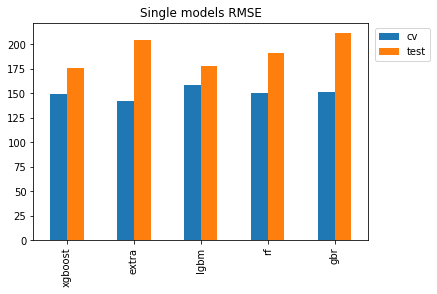

In [ ]:
import matplotlib.pyplot as plt

single_model_rmse.plot(kind='bar')
plt.title('Single models RMSE')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

# 스태킹 모델 구축

스태킹에 활용할 단일모델에 대한 최적화는 마쳤다. 이제 스태킹모델을 구축해보자. 스태킹 역시 여러가지 모델들을 시도했다. **regressor**에는 최적화를 마친 5개의 단일 모델을 모두 사용하고, **meta_regressor**에서 5개의 모델을 하나씩 써보면서 성능을 비교했다. 

스태킹 모델들의 교차검증, Test데이터의 RMSE를 각각 정리할, **stacking_cv_rmse_result, stacking_test_rmse_result** 딕셔너리 생성

In [ ]:
stacking_cv_rmse_result = dict()
stacking_test_rmse_result = dict()

스태킹 모델을 구축하기 위해 StackingCVRegressor를 import 한다.

In [ ]:
from mlxtend.regressor import StackingCVRegressor

##Meta_Regressor-XGBRegressor

meta_regressor에 XGBRegressor를 사용해서 성능을 확인한다.

-> 단일모델에 비해 확실히 과대적합이 완화되었고, 교차검증의 RMSE 역시 줄어들었다.

In [ ]:
stack_model = StackingCVRegressor(regressors=(models['xgboost'], models['extra'], models['lgbm'],
                                              models['rf'], models['gbr']),
                                  meta_regressor=models['xgboost'], use_features_in_secondary=True)

print('훈련데이터 성능', end=' >> ')
train_eval_rmse(stack_model, X_train, y_train , X_train, y_train)
print('교차검증', end=' >> ')
stacking_cv_rmse_result['stacking_xg'] = evaluate_model_cv(stack_model, X_train, y_train)

훈련데이터 성능 >> this model RMSE is 98.7735
교차검증 >> this model RMSE is 101.2904


Test 데이터를 활용해, 최종성능을 확인한다.

In [ ]:
print('최종확인', end=' >> ')
stacking_test_rmse_result['stacking_xg'] = train_eval_rmse(stack_model, X_train, y_train, X_test, y_test)

최종확인 >> this model RMSE is 130.3940


##Meta_Regressor-ExtraTreeRegressor

meta_regressor에 ExtraTreeRegressor를 사용해서 성능을 확인한다.

-> 단일모델에 비해 확실히 과대적합이 완화되었고, 교차검증의 RMSE 역시 줄어들었다.

In [ ]:
stack_model = StackingCVRegressor(regressors=(models['xgboost'], models['extra'], models['lgbm'],
                                              models['rf'], models['gbr']),
                                  meta_regressor=models['extra'], use_features_in_secondary=True)

print('훈련데이터 성능', end=' >> ')
train_eval_rmse(stack_model, X_train, y_train , X_train, y_train)
print('교차검증', end=' >> ')
stacking_cv_rmse_result['stacking_extra'] = evaluate_model_cv(stack_model, X_train, y_train)

훈련데이터 성능 >> this model RMSE is 31.3143
교차검증 >> this model RMSE is 109.7290


Test 데이터를 활용해, 최종성능을 확인한다.

In [ ]:
print('최종확인', end=' >> ')
stacking_test_rmse_result['stacking_extra'] = train_eval_rmse(stack_model, X_train, y_train, X_test, y_test)

최종확인 >> this model RMSE is 148.3732


##Meta_Regressor-LGBM

meta_regressor에 LGBM을 사용해서 성능을 확인한다.

-> 단일모델에 비해 확실히 과대적합이 완화되었고, 교차검증의 RMSE 역시 줄어들었다.

In [ ]:
stack_model = StackingCVRegressor(regressors=(models['xgboost'], models['extra'], models['lgbm'],
                                              models['rf'], models['gbr']),
                                  meta_regressor=models['lgbm'], use_features_in_secondary=True)

print('훈련데이터 성능', end=' >> ')
train_eval_rmse(stack_model, X_train, y_train , X_train, y_train)
print('교차검증', end=' >> ')
stacking_cv_rmse_result['stacking_lgbm'] = evaluate_model_cv(stack_model, X_train, y_train)

훈련데이터 성능 >> this model RMSE is 111.7974
교차검증 >> this model RMSE is 111.3157


Test 데이터를 활용해, 최종성능을 확인한다.

In [ ]:
print('최종확인', end=' >> ')
stacking_test_rmse_result['stacking_lgbm'] = train_eval_rmse(stack_model, X_train, y_train, X_test, y_test)

최종확인 >> this model RMSE is 144.3497


## Meta_Regressor-RandomForestRegressor

meta_regressor에 RandomForestRegressor를 사용해서 성능을 확인한다.

-> 단일모델에 비해 확실히 과대적합이 완화되었고, 교차검증의 RMSE 역시 줄어들었다.

In [ ]:
stack_model = StackingCVRegressor(regressors=(models['xgboost'], models['extra'], models['lgbm'],
                                              models['rf'], models['gbr']),
                                  meta_regressor=models['rf'], use_features_in_secondary=True)

#과적합 확인
print('훈련데이터 성능', end=' >> ')
train_eval_rmse(stack_model, X_train, y_train , X_train, y_train)
print('교차검증', end=' >> ')
stacking_cv_rmse_result['stacking_rf'] = evaluate_model_cv(stack_model, X_train, y_train)

훈련데이터 성능 >> this model RMSE is 29.3312
교차검증 >> this model RMSE is 113.9906


Test 데이터를 활용해, 최종성능을 확인한다.

In [ ]:
print('최종확인', end=' >> ')
stacking_test_rmse_result['stacking_rf'] = train_eval_rmse(stack_model, X_train, y_train, X_test, y_test)

최종확인 >> this model RMSE is 156.6355


##Meta_Regressor-GradientBoostRegressor

meta_regressor에 GradientBoostRegressor를 사용해서 성능을 확인한다.

-> 단일모델에 비해 확실히 과대적합이 완화되었고, 교차검증의 RMSE 역시 줄어들었다.

In [ ]:
stack_model = StackingCVRegressor(regressors=(models['xgboost'], models['extra'], models['lgbm'],
                                              models['rf'], models['gbr']),
                                  meta_regressor=models['rf'], use_features_in_secondary=True)

#과적합 확인
print('훈련데이터 성능', end=' >> ')
train_eval_rmse(stack_model, X_train, y_train , X_train, y_train)
print('교차검증', end=' >> ')
stacking_cv_rmse_result['stacking_gbr'] = evaluate_model_cv(stack_model, X_train, y_train)

훈련데이터 성능 >> this model RMSE is 27.0745
교차검증 >> this model RMSE is 114.0257


Test 데이터를 활용해, 최종성능을 확인한다.

In [ ]:
print('최종확인', end=' >> ')
stacking_test_rmse_result['stacking_gbr'] = train_eval_rmse(stack_model, X_train, y_train, X_test, y_test)

최종확인 >> this model RMSE is 158.9574


## 스태킹 모델 정리

stacking_cv_rmse_result, stacking_test_rmse_result 결과를 **stacking_model_rmse 데이터프레임**에 정리한후, 확인한다.

In [ ]:
print('********Stacking 모델의 RMSE 확인********')
stacking_model_cv_data = pd.DataFrame(stacking_cv_rmse_result, index=['cv']).transpose()
stacking_model_test_data = pd.DataFrame(stacking_test_rmse_result, index=['test']).transpose()
stacking_model_rmse = pd.concat([stacking_model_cv_data,stacking_model_test_data],axis=1)
stacking_model_rmse

********Stacking 모델의 RMSE 확인********


,cv,test
stacking_xg,101.290417,130.393954
stacking_extra,109.728971,148.373156
stacking_lgbm,111.315662,144.349711
stacking_rf,113.990601,156.635513
stacking_gbr,114.025729,158.957407


스태킹모델의 RMSE를 **시각화**하여 확인한다.

-> **XGBRegressor를 meta_regressor로 사용한** 스태킹모델이 Test 데이터에 대한 


RMSE를 기준으로 가장 좋은 성능을 낸다는 것을 확인할 수 있다.

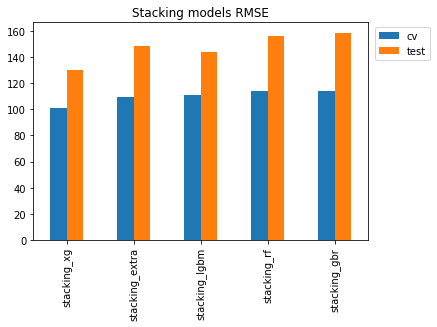

In [ ]:
stacking_model_rmse.plot(kind='bar')
plt.title('Stacking models RMSE')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

# 전체모델 RMSE 시각화 및 최종모델 결정

단일모델의 RMSE를 담고있는 singe_model_rmse와 스태킹 모델의 RMSE를 담고 있는 stacking_model_rmse를 **total_model_rmse 데이터프레임**으로 합친 후, 확인한다.

In [ ]:
print('********전체 모델의 RMSE 확인********')
total_model_rmse = pd.concat([single_model_rmse,stacking_model_rmse],axis=0)
total_model_rmse

********전체 모델의 RMSE 확인********


,cv,test
xgboost,149.378102,175.748694
extra,142.591362,204.667971
lgbm,158.190462,178.434810
rf,149.952729,191.106729
gbr,151.834310,211.646004
stacking_xg,101.290417,130.393954
stacking_extra,109.728971,148.373156
stacking_lgbm,111.315662,144.349711
stacking_rf,113.990601,156.635513
stacking_gbr,114.025729,158.957407


전체모델의 RMSE를 시각화하여 확인한다.

-> 스테킹 모델의 RMSE가 전체적으로 단일모델의 RMSE보다 낮다. **최종모델**은 스태킹 모델 중 가장 좋은 성능을 보여준 **XGBRegressor를 meta_regressor로 사용한 스태킹 모델**을 택함.

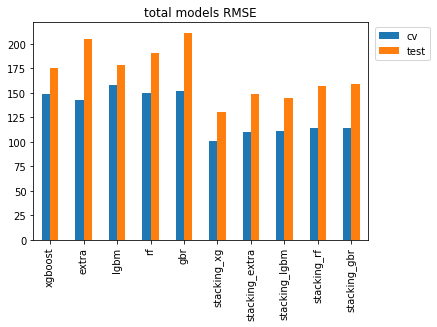

In [ ]:
total_model_rmse.plot(kind='bar')
plt.title('total models RMSE')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

# 평가 데이터(26번 홍수사상) 예측 및 엑셀 파일로 저장

모델 기반 칼럼 선택으로 선택된 칼럼을 확인한다.

In [ ]:
columns_selected

MultiIndex([(            1,        'rainfall_A'),
            (            1,        'rainfall_C'),
            (            1,        'rainfall_D'),
            (            1,      'waterlevel_E'),
            (            2,      'waterlevel_D'),
            (            3,        'rainfall_B'),
            (            3,        'rainfall_D'),
            (            4, 'rainfall_mean_all'),
            (            4,        'rainfall_A'),
            (            4,        'rainfall_C'),
            (            4,        'rainfall_D'),
            (            4,      'waterlevel_D'),
            (            5, 'rainfall_mean_all'),
            (            6, 'rainfall_mean_all'),
            (            6,        'rainfall_C'),
            (            6,        'rainfall_D'),
            (        'day',                  ''),
            (       '소양강댐',            'inflow'),
            (       '소양강댐',         'discharge'),
            (        '횡성댐',        'waterlevel'),


평가데이터(홍수사상 26번)를 담고 있는 X_eval_df에 선택된 칼럼을 적용한 후, shape를 확인한다.

In [ ]:
X_eval_df[columns_selected].shape

(160, 78)

최종모델을 확인한다.

In [ ]:
final_model = StackingCVRegressor(regressors=(models['xgboost'], models['extra'], models['lgbm'],
                                              models['rf'], models['gbr']),
                                  meta_regressor=models['rf'], use_features_in_secondary=True)

최종모델을 훈련데이터를 이용해 훈련시킨다.

In [ ]:
final_model.fit(X_train, y_train)

StackingCVRegressor(cv=5,
                    meta_regressor=RandomForestRegressor(bootstrap=False,
                                                         ccp_alpha=0.0,
                                                         criterion='mse',
                                                         max_depth=100,
                                                         max_features='log2',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.1,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                           

훈련을 마친 최종 모델에 평가데이터를 입력하여 예측한다.

In [ ]:
prediction = model.predict(X_eval_df[columns_selected].values)

예측값을 엑셀파일에 입력 후 저장한다.

In [ ]:
from openpyxl import load_workbook


workbook = load_workbook('eval_data.xlsx')
worksheet = workbook['평가데이터']

for i, value in enumerate(prediction):
    cell = 'F%d' % (i + 3)
    worksheet[cell] = value

workbook.save('데이터분석분야_퓨처스리그_홍수ZERO_최적00_평가데이터.xlsx')